In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

import os
from typing import List, Tuple, Dict
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
from tqdm import tqdm

In [10]:
data_path = r"D:\Projects\deeplearningproject\artifact\11_08_2024_23_22_48\data_ingestion\data"
os.path.exists(data_path)

True

In [11]:
#define class name
class_name = ['NORMAL','PNEUMONIA']

In [12]:
def get_file_list(path) -> List:
    """
    input: file path
    output: list of files name
    """

    return os.listdir(path)

In [13]:
normal_image_train = data_path+"/train/"+class_name[0]
os.path.exists(normal_image_train)

True

In [14]:
normal_image = get_file_list(normal_image_train)
normal_image[:10]

['IM-0001-0001.jpeg',
 'IM-0003-0001.jpeg',
 'IM-0005-0001.jpeg',
 'IM-0006-0001.jpeg',
 'IM-0007-0001.jpeg',
 'IM-0009-0001.jpeg',
 'IM-0010-0001.jpeg',
 'IM-0011-0001-0001.jpeg',
 'IM-0011-0001-0002.jpeg',
 'IM-0011-0001.jpeg']

In [15]:
rand_img_no = np.random.randint(0,len(normal_image))
rand_img_no

13

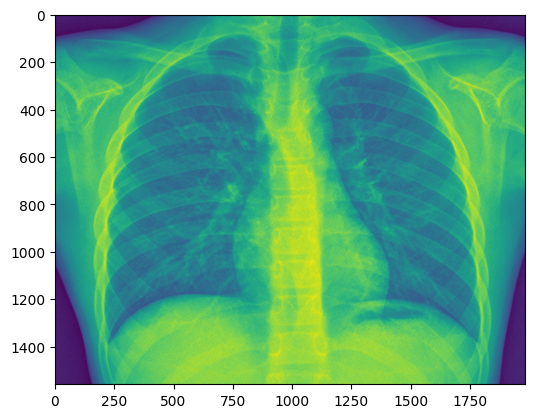

In [16]:
img = normal_image_train+"/"+normal_image[rand_img_no]

plt.imshow(plt.imread(img))

## transforming the imgaes
- Now that we have seen the sample of the images let's transform the data now
- We need to perform transformation on both train and test images
- For Training data we need to perform the data augmentation also.
- Data Augmentation is done to create synthetic data.

In Transformation we are doing Resize,CenterCrop,ColorJitter,RandomHorizontalFlip,RandomRotation,ToTensor and Normalize.

- Resize:- Resize the input image to the given size.
- CenterCrop:- Crops the given image at the center.
- ColorJitter:- Randomly change the brightness, contrast, saturation and hue of an image.
- RandomHorizontalFlip:- Horizontally flip the given image randomly with a given probability.
- RandomRotation:- Rotate the image by angle.
- ToTensor:- Convert numpy.ndarray to tensor.
- Normalize:- Normalize a float tensor image with mean and standard deviation.

In [17]:
train_transform = transforms.Compose([
transforms.Resize(224),
transforms.CenterCrop(224),
transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(10),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
transforms.Resize(224),
transforms.CenterCrop(224),
# transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
# transforms.RandomHorizontalFlip(),
# transforms.RandomRotation(10),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])

])

In [18]:
train_data = datasets.ImageFolder(os.path.join(data_path,'train'),transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path,'test'),transform=test_transform)

In [19]:
train_data_loader = DataLoader(train_data,batch_size=2, shuffle=True, pin_memory=True)
test_data_loader = DataLoader(test_data,batch_size=2, shuffle=False, pin_memory=True)

In [20]:
import pickle, joblib
with open("train_data_loader.pkl","wb") as f:
    pickle.dump(train_data_loader,f)
    f.close()

In [21]:
with open("train_data_loader.pkl","rb") as f:
    x = pickle.load(f)
    f.close()

loaded_data = DataLoader(x)

In [22]:
type(loaded_data)

torch.utils.data.dataloader.DataLoader

In [23]:
from Xray.components.model_evaluation import ModelEvaluation
from Xray.entity.artifact_entity import DataTransformationArtifact, ModelTrainingArtifcat
from Xray.entity.config_entity import ModelEvaluationConfig

In [24]:
#defining path
train_transform_data_path = r"D:\Projects\deeplearningproject\artifact\11_08_2024_23_22_48\data_transformation\train_transforms.pkl"
test_transform_data_path = r"D:\Projects\deeplearningproject\artifact\11_08_2024_23_22_48\data_transformation\test_transforms.pkl"
model_path = r"D:\Projects\deeplearningproject\artifact\11_08_2024_23_22_48\trained_model\model.pt"

In [25]:
def file_generator(path):
    with open(path,"rb") as f:
        x = joblib.load(f)
        f.close()
    return DataLoader(x)


In [26]:
train_transformer = file_generator(train_transform_data_path)
test_transformer= file_generator(test_transform_data_path)


In [27]:
test_data_path = r"D:\Projects\deeplearningproject\artifact\11_08_2024_23_22_48\data_ingestion\data\test"
train_data_path = r"D:\Projects\deeplearningproject\artifact\11_08_2024_23_22_48\data_ingestion\data\train"
test_data1 = datasets.ImageFolder(test_data_path,transform=test_transform)
train_data1 = datasets.ImageFolder(train_data_path,transform=train_transform)

In [28]:
train_data_loader1 = DataLoader(train_data1)
test_data_loader1 = DataLoader(test_data1)

In [29]:
data_tranform_artifact = DataTransformationArtifact(
    transformed_train_object=train_data_loader1,
    train_transform_file_path= train_transform_data_path,
    transformed_test_object=test_data_loader1,
    test_transform_file_path= test_transform_data_path
)

In [30]:
model_articat = ModelTrainingArtifcat(
    trained_model_path=model_path
)

In [31]:
config = ModelEvaluationConfig()
eval_model = ModelEvaluation(data_transformation_artifact=data_tranform_artifact,
                             model_evaluation_config=config,
                             model_trainer_artifact=model_articat)
eval_model.initiate_model_evaluation()

ModelEvaluationArtifact(model_accuracy=55.00000000000001)

In [32]:
from Xray.pipeline.training_pipeline import TrainPipeline

pipe = TrainPipeline()

pipe.start_model_evaluation(model_trainer_artifact=model_articat,
                            data_transformation_artifact=data_tranform_artifact)

ModelEvaluationArtifact(model_accuracy=55.00000000000001)

In [33]:
pipe.run_pipeline()

Epoch :  1


Loss=8.070128387771547e-05 Batch_id=104 Accuracy=96.67: 100%|██████████| 105/105 [00:05<00:00, 19.19it/s] 


Test set: Average loss: 6.8002, Accuracy: 30/60 (50.00%)

